**<h1 align="center">Text Mining</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

<a class="anchor" id="chapter1"></a>

# 1. Imports

</a>

In [8]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [10]:
from tqdm import tqdm

In [11]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem import WordNetLemmatizer, PorterStemmer

In [12]:
import gensim
from gensim.models import Word2Vec

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

In [14]:
# Set the style for seaborn
sns.set(style="white")

In [15]:
import os
print(os.getcwd())


c:\Users\ruben\Desktop\Universidade\Nova IMS\2nd Semester\Text Mining\Project\Text-Mining-Project\Notebooks


In [16]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

In [17]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [18]:
# Set id as index
df_test.set_index('id', inplace=True)

In [19]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [20]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

In [21]:
df_train["label"].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

In [22]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

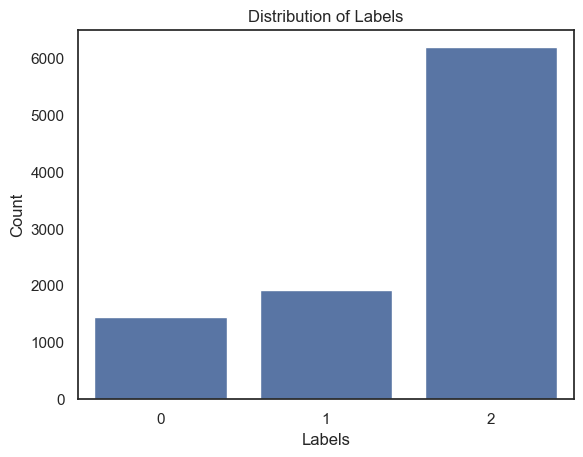

In [23]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

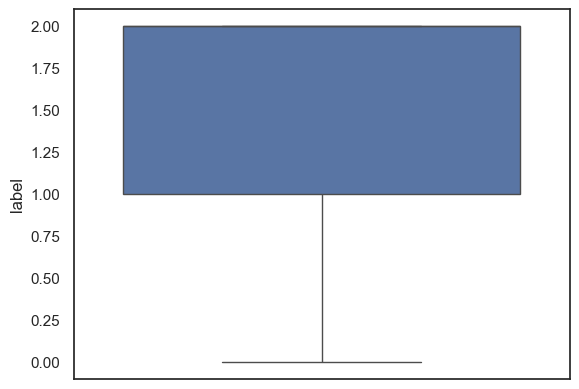

In [24]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

In [25]:
# Fetch wordcount for each abstract
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [26]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

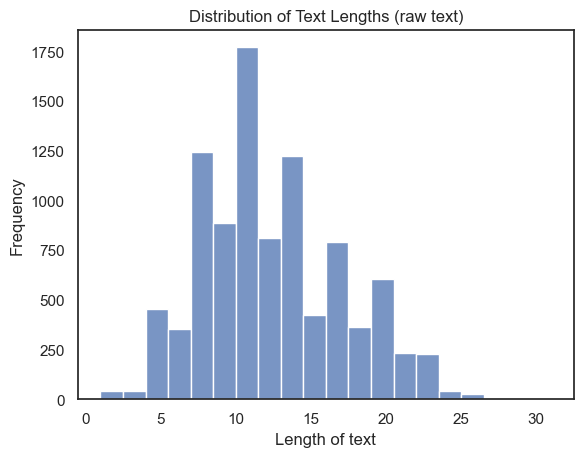

In [27]:
# Plot distribution of text length
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [28]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

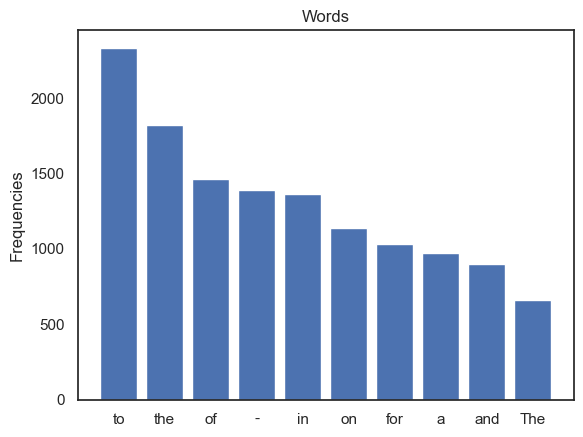

In [29]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

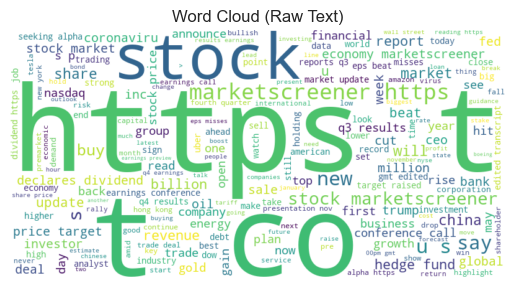

In [30]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

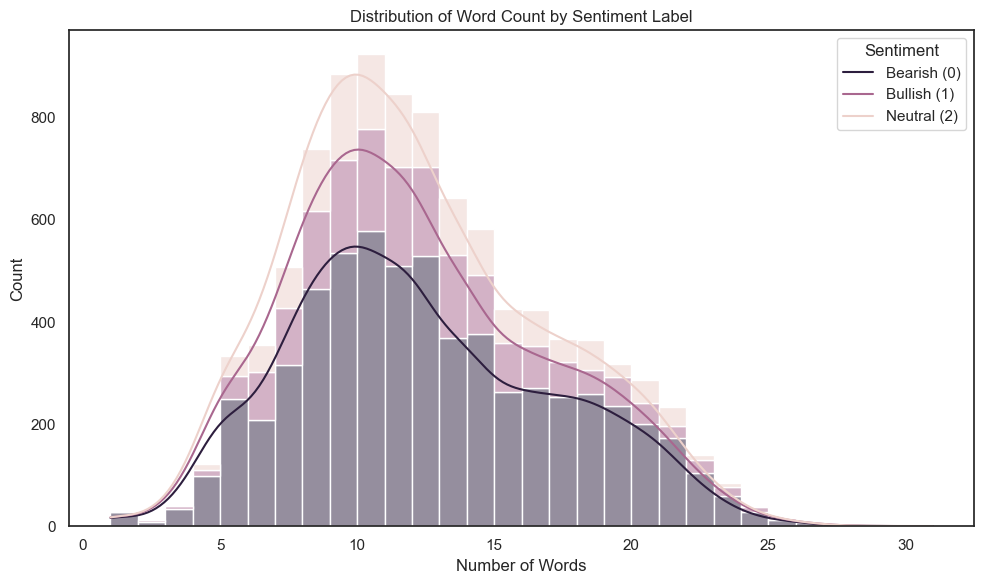

In [31]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

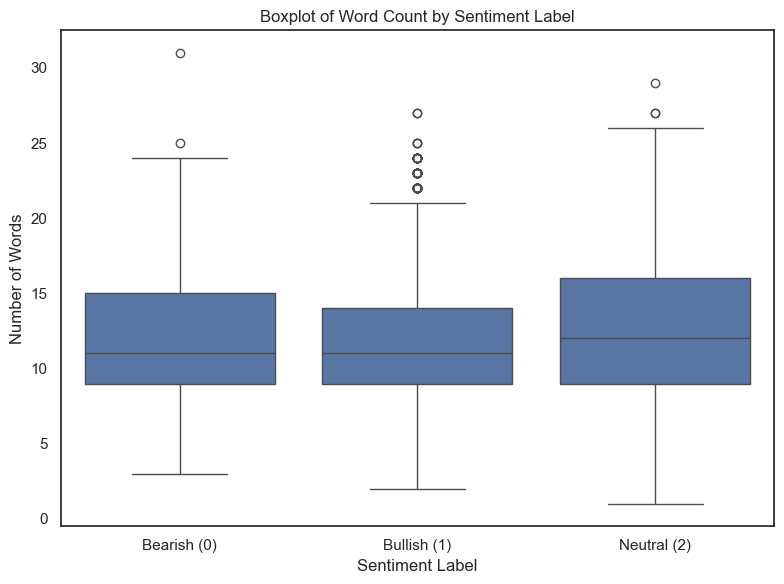

In [32]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [33]:
# Simple text cleaner
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # remove mentions and hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # keep only letters
    return text

# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [34]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

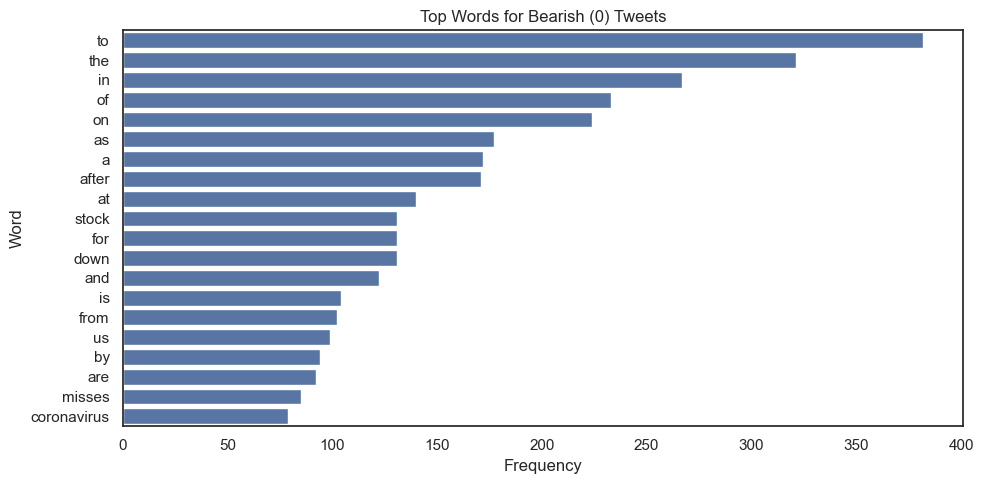

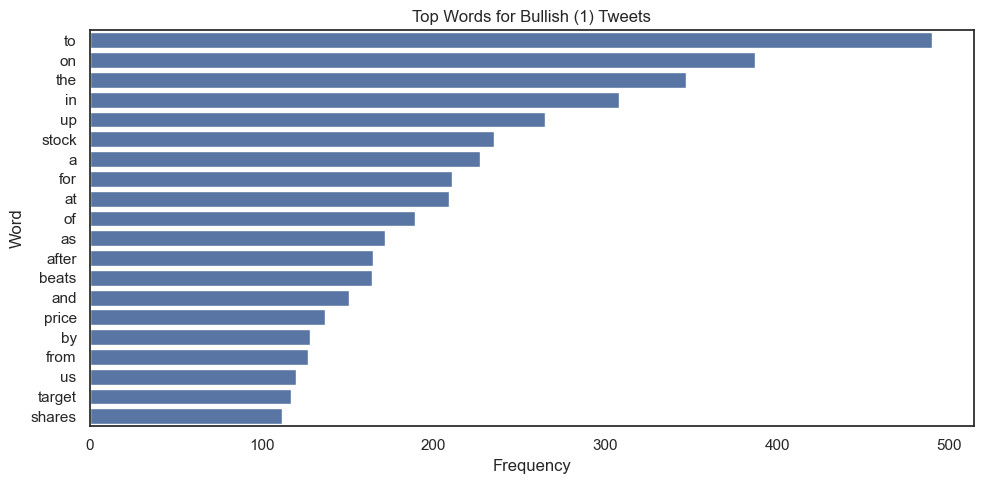

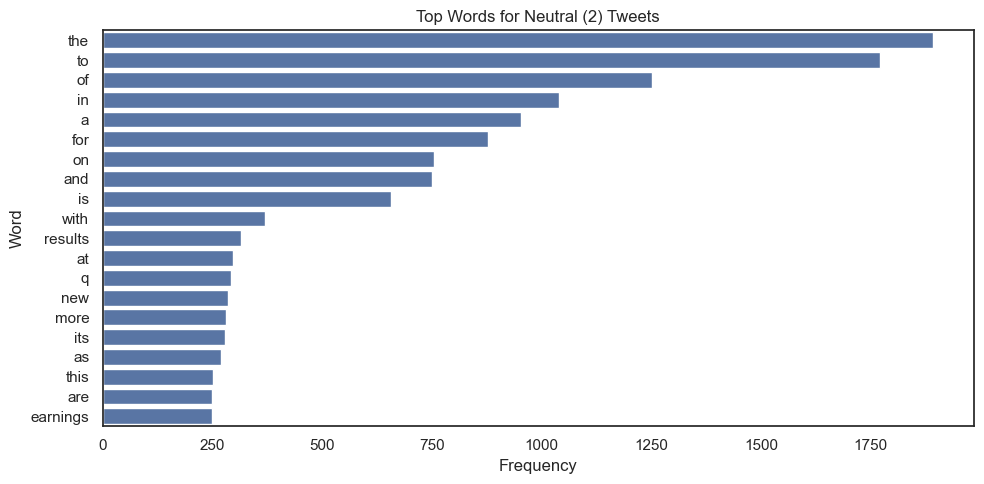

In [35]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [36]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text'].apply(clean_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

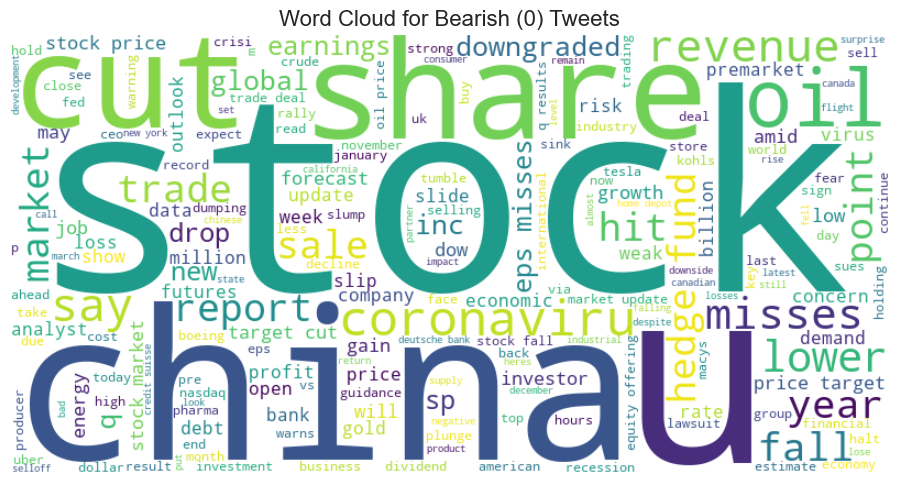

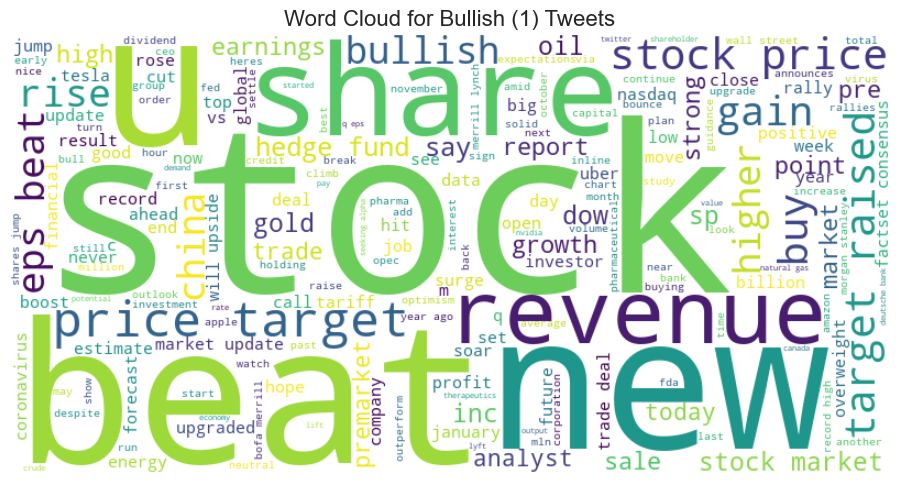

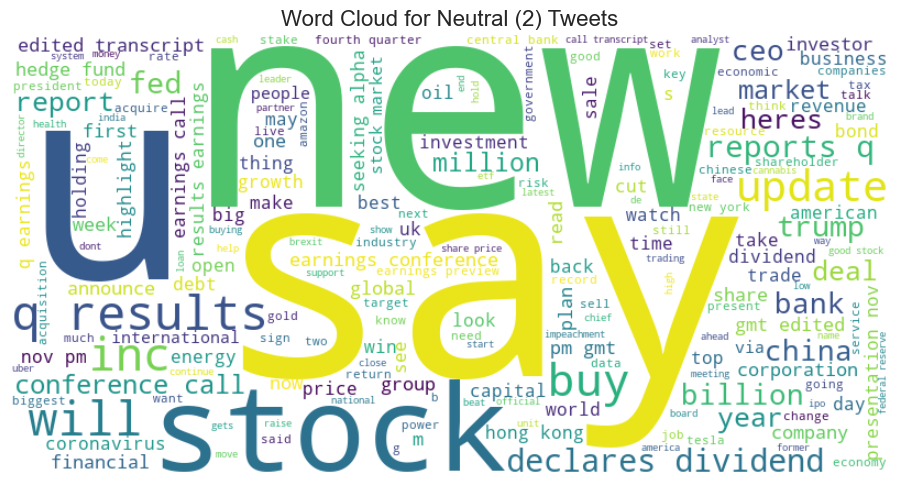

In [37]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

In [38]:
# Create a character count column
df_train['char_count'] = df_train['text'].apply(len)

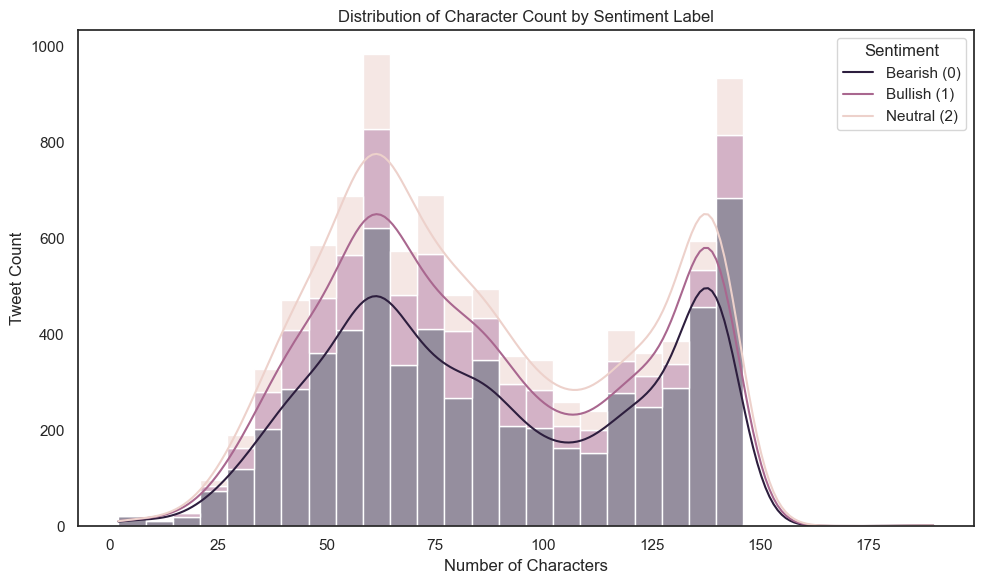

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

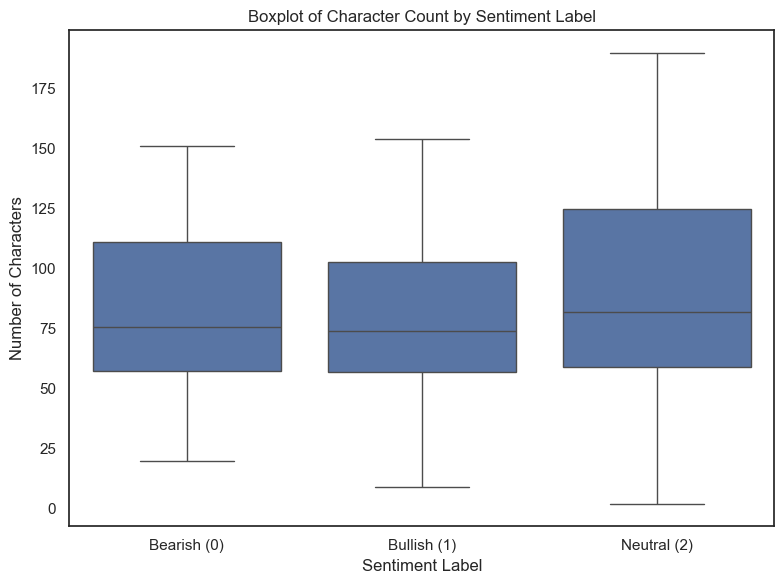

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [41]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [42]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

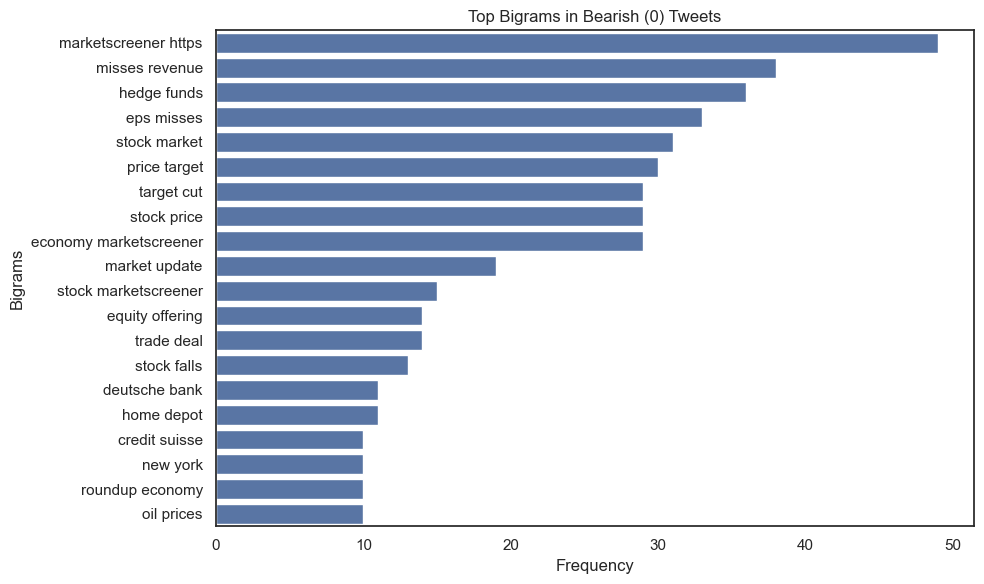

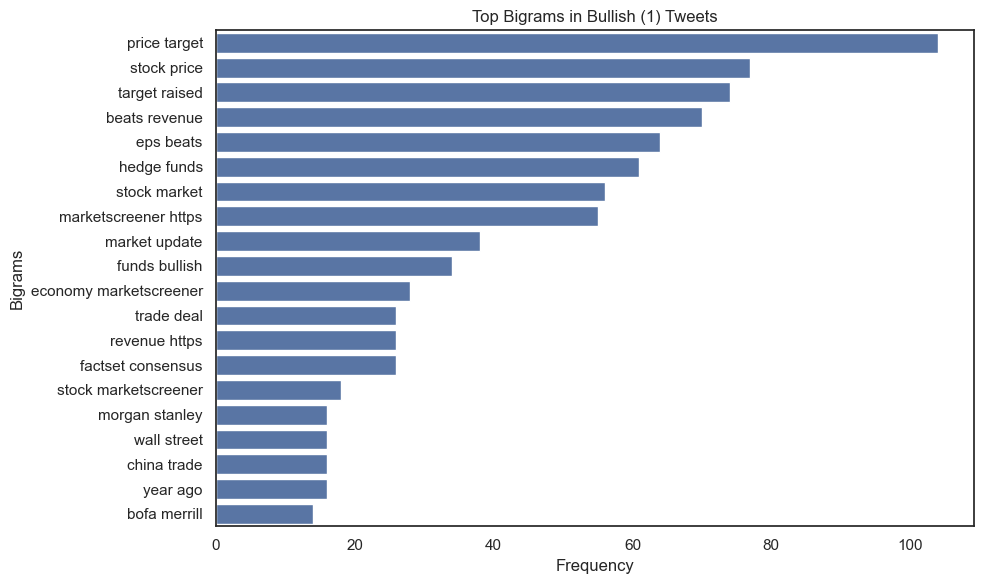

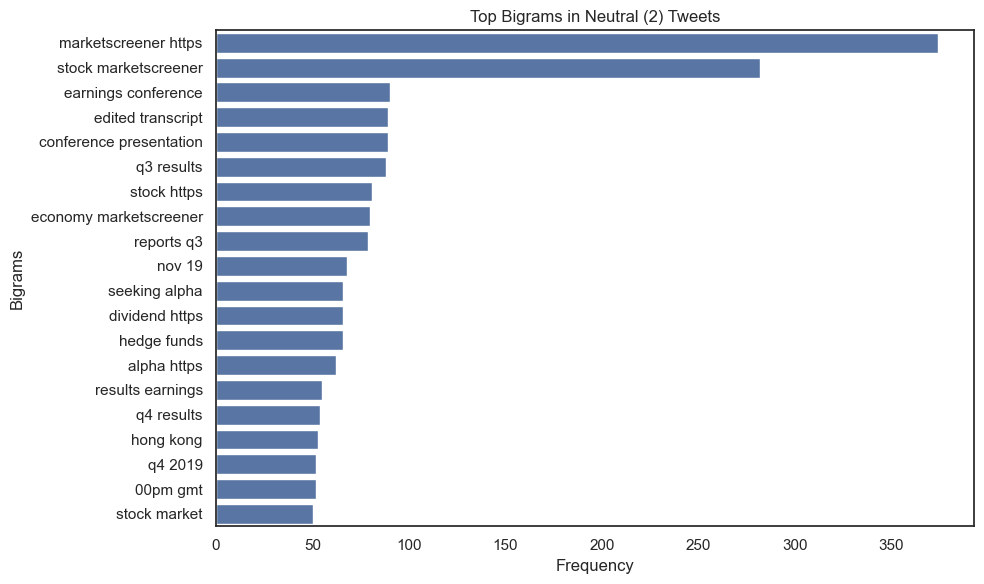

In [43]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

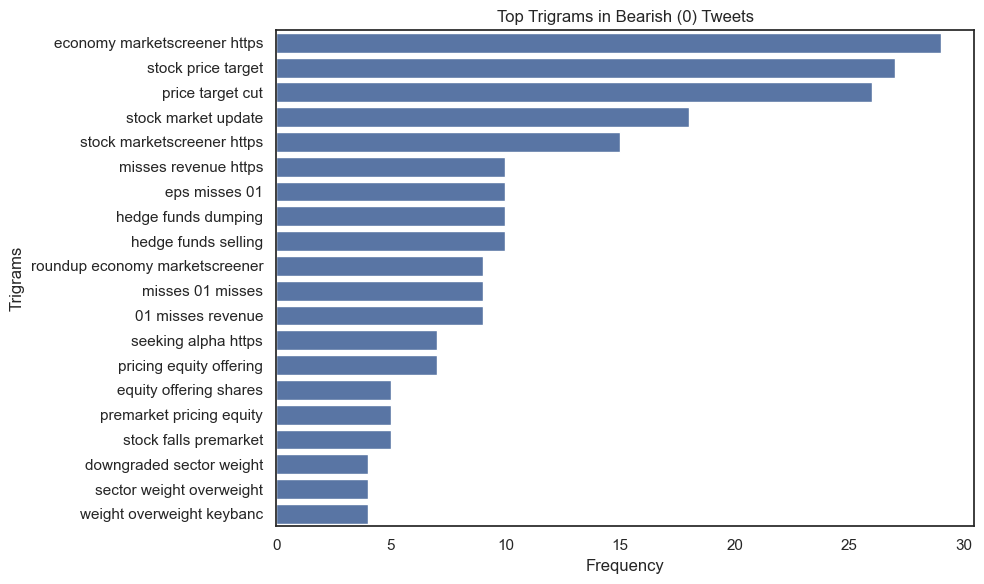

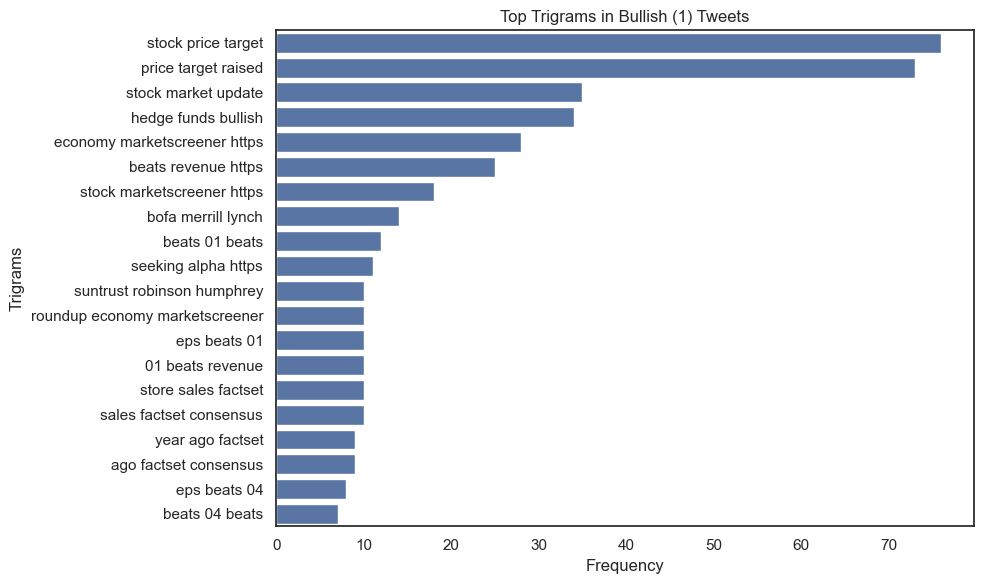

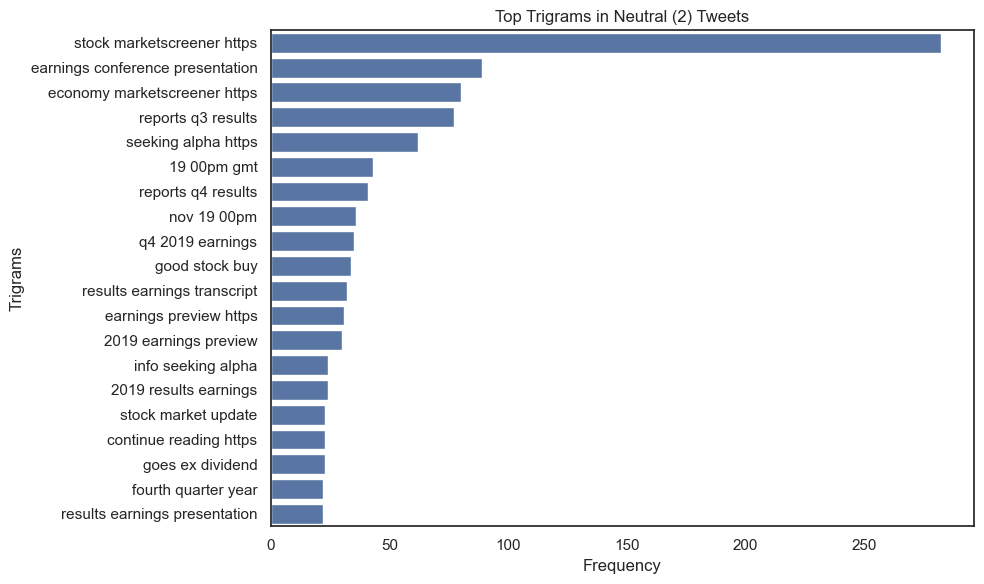

In [44]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

In [45]:
# Function to get top TF-IDF terms
def get_top_tfidf_terms(corpus, top_n=20, ngram_range=(1,1)):
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
    X = tfidf.fit_transform(corpus)
    scores = X.sum(axis=0).A1
    terms = tfidf.get_feature_names_out()
    tfidf_df = pd.DataFrame({'term': terms, 'score': scores})
    top_terms = tfidf_df.sort_values(by='score', ascending=False).head(top_n)
    return top_terms

In [46]:
# Function to plot top TF-IDF terms
def plot_top_tfidf_terms(tfidf_df, title='Top TF-IDF Terms'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='term', data=tfidf_df)
    plt.title(title)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

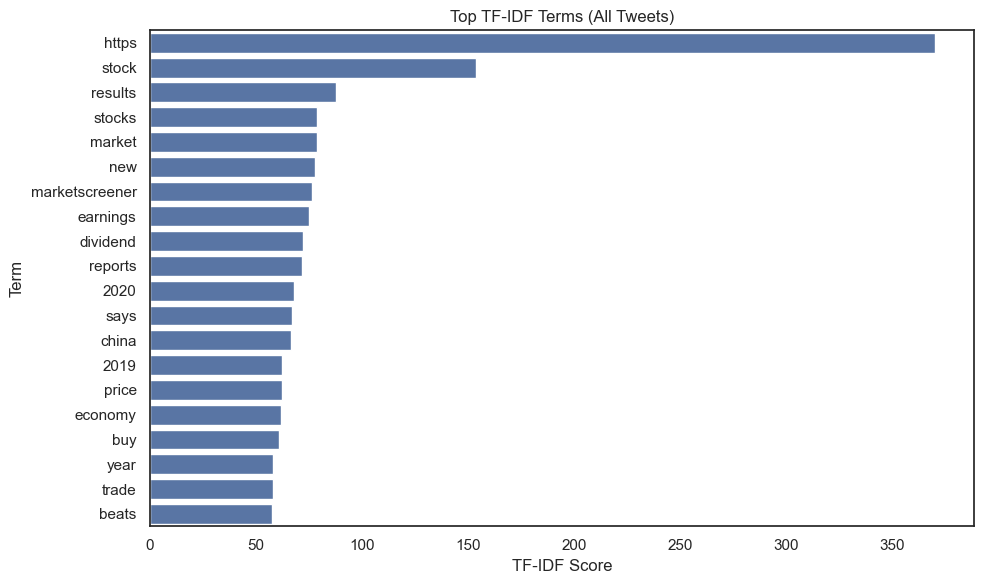

In [47]:
global_tfidf = get_top_tfidf_terms(df_train['text'].str.lower(), top_n=20)
plot_top_tfidf_terms(global_tfidf, title='Top TF-IDF Terms (All Tweets)')

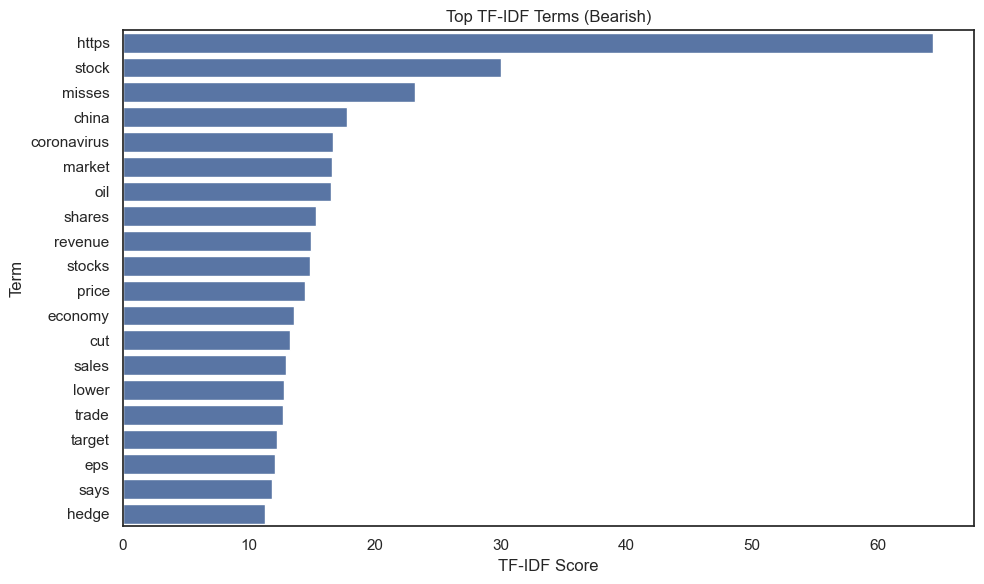

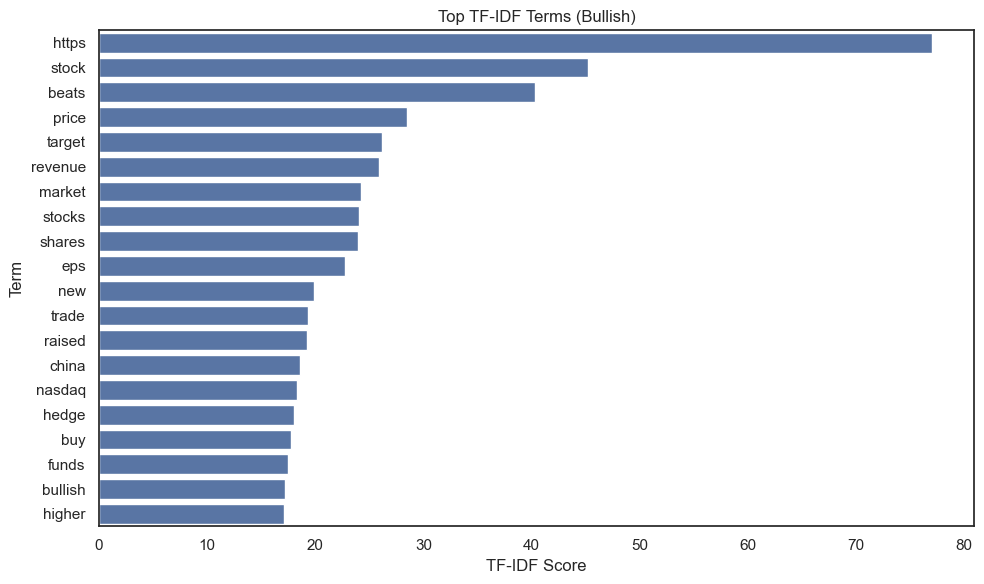

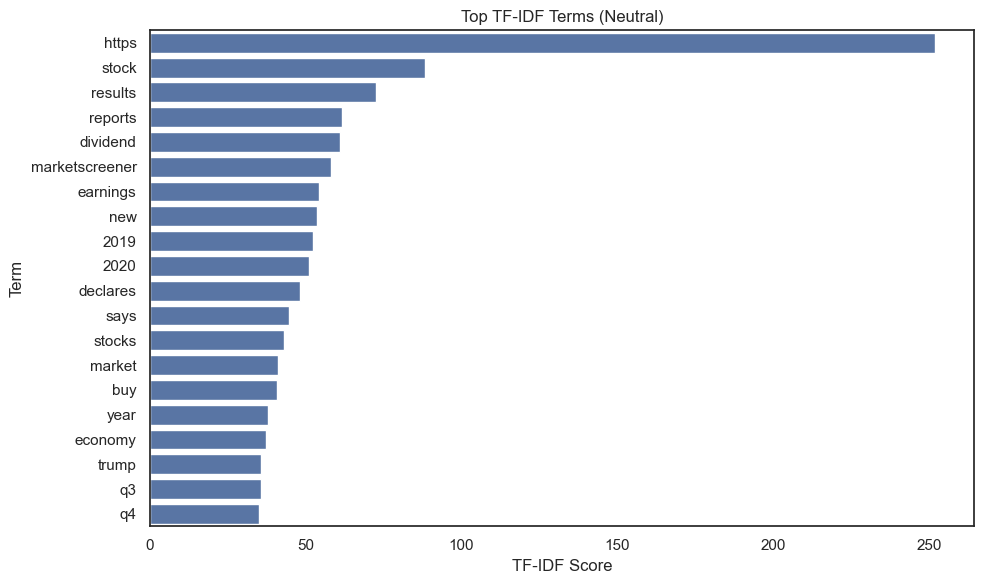

In [48]:
# Bearish (0)
bearish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 0]['text'].str.lower())
plot_top_tfidf_terms(bearish_tfidf, title='Top TF-IDF Terms (Bearish)')

# Bullish (1)
bullish_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 1]['text'].str.lower())
plot_top_tfidf_terms(bullish_tfidf, title='Top TF-IDF Terms (Bullish)')

# Neutral (2)
neutral_tfidf = get_top_tfidf_terms(df_train[df_train['label'] == 2]['text'].str.lower())
plot_top_tfidf_terms(neutral_tfidf, title='Top TF-IDF Terms (Neutral)')

<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.20, stratify=df_train['label'], random_state=4)

In [50]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7634, 1909, 7634, 1909)

<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>

In [51]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ruben\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [52]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [53]:
def preprocess_text(text, do_lemmatize=True, do_stem=False):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"\@\w+|\#\w+", '', text)                            # Remove mentions and hashtags
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)     # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenization
    tokens = nltk.word_tokenize(text)

    # 4. Stop word removal
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization and Stemming
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    if do_stem:
        tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

In [54]:
X_train_cleaned = X_train.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))
X_test_cleaned = X_test.apply(lambda x: preprocess_text(x, do_lemmatize=True, do_stem=False))

In [55]:
# Check before and after cleaning
print("Original tweet:\n", X_train.iloc[6])
print("Cleaned tweet:\n", X_train_cleaned.iloc[6])

Original tweet:
 What Matters For 'Newly Christened Macro Bulls'. Follow this and any other stock on Seeking Alpha!… https://t.co/kzzahcB8Ue
Cleaned tweet:
 matter newly christened macro bull follow stock seeking alpha


<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>

<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>

In [56]:
def extract_bow_features(train_texts, test_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_test, vectorizer

In [57]:
BoW_X_train, BoW_X_test, bow_vectorizer = extract_bow_features(X_train_cleaned, X_test_cleaned)

In [58]:
term_counts = np.array(BoW_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)

In [59]:
top_terms_df.head(10)

,term,count
10399,stock,662
6534,market,338
9112,report,319
7286,new,317
9555,say,308
8533,price,307
9185,result,283
9816,share,274
3276,earnings,261
5316,inc,240


<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>

In [60]:
def extract_tfidf_features(train_texts, test_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_test = vectorizer.transform(test_texts).toarray()
    return X_train, X_test, vectorizer

In [61]:
tfidf_X_train, tfidf_X_test, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_test_cleaned)

In [62]:
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]

[('fiveyear', 9.247351037092788),
 ('fix', 7.9945880685974196),
 ('fixed', 8.331060305218632),
 ('fixedincome', 9.247351037092788),
 ('fixing', 8.841885928984624),
 ('fizz', 9.247351037092788),
 ('fizzle', 8.841885928984624),
 ('fj', 9.247351037092788),
 ('fl', 7.9945880685974196),
 ('flag', 7.9945880685974196)]

<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>

In [63]:
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)

In [64]:
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_test = [text.split() for text in X_test_cleaned]

In [65]:
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

In [66]:
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_test = get_average_word2vec(X_test_cleaned, w2v_model)

<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Transformer (BERT)

</a>

In [69]:

# %pip install tf-keras

from transformers import (
    DistilBertTokenizer,
    DistilBertTokenizerFast,
    DistilBertModel,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch

In [70]:

# Load tokenizer and model
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')


# 1) Disable dropout
bert_model.eval()

# 2) Batch-embed helper
def transformer_embeddings(texts, batch_size=32):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = bert_tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            out = bert_model(**enc)
        # out.last_hidden_state: (batch, seq_len, hidden_dim)
        mask   = enc.attention_mask.unsqueeze(-1)           # (batch, seq_len, 1)
        summed = (out.last_hidden_state * mask).sum(dim=1)   # sum over seq_len
        counts = mask.sum(dim=1)                            # number of real tokens
        embs   = (summed / counts).cpu().numpy()            # mean‐pooled vectors
        all_embs.append(embs)
    return np.vstack(all_embs)

# 3) Embed your splits
X_train_transformer = transformer_embeddings(X_train_cleaned.tolist())
X_test_transformer  = transformer_embeddings(X_test_cleaned.tolist())

<a class="anchor" id="sub-section-5_5"></a>

## 5.5. Extra method 1

</a>

Meta/Facebook pre-trained English word-vector model

<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Extra method 2

</a>

Sentence-Transformer (SBERT) for Financial Sentences

https://huggingface.co/ohsuz/k-finance-sentence-transformer

In [92]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [93]:
from transformers import AutoTokenizer, AutoModel
import torch

from sentence_transformers import SentenceTransformer

# Load the finance-tuned SBERT
sbert = SentenceTransformer("ohsuz/k-finance-sentence-transformer")

# Encode
sbert_X_train = sbert.encode(X_train.tolist(), show_progress_bar=True)
sbert_X_test  = sbert.encode(X_test.tolist(),  show_progress_bar=True)

c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ruben\.cache\huggingface\hub\models--ohsuz--k-finance-sentence-transformer. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Batches: 100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


# CHLOE 

The models are structured the way you did; you can add the ones from my notebook. I kept your evaluation code (from you) and created a function that stores all results. I also reviewed Diogo’s notebook and saw that he didn’t try every model/feature combination (maybe I’m wrong), so I think we should use the feature sets from my notebook.

Tomorrow i will try and do the remaining models (LSTM and Encoder and pretrained models).
 One question that i have for you is, should we fine tune them? (there's no problem if we have/should, i will try to do it until saturday and run the entire notebook after it)

Anyway, if you have any question fell free to ask.

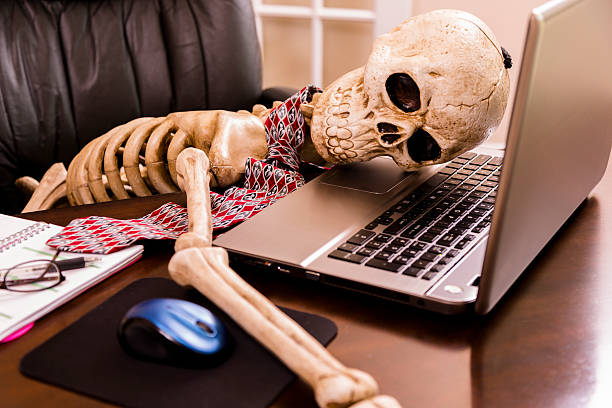

<a class="anchor" id="chapter6"></a>

# 6. Models

</a>

<a class="anchor" id="sub-section-6_1"></a>

## 6.1. KNN

</a>

In [96]:
import pandas as pd


results_columns = ["Model","Representation","Train_F1","Val_F1",]

results = pd.DataFrame(columns=results_columns)


def log_result(
    model_name: str,
    feat_name: str,
    train_accuracy=None,
    train_f1=None,
    val_accuracy=None,
    val_f1=None,
):
    """
    Append one row to the global `results` table.
    """
    global results
    row = {
        "Model": model_name,
        "Representation": feat_name,
        "Train_F1": train_f1,
        "Val_F1": val_f1,
    }
    # .loc is faster & future-proof vs. append()
    results.loc[len(results)] = row

def show():
    print(results.to_string(index=False))
    

def evaluate_and_log(
    model_name, feat_name, model, X_tr, y_tr, X_te, y_te
):
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    log_result(
        model_name,
        feat_name,
        train_f1=f1_score(y_tr, y_tr_pred, average="macro"),
        val_f1=f1_score(y_te, y_te_pred, average="macro"),
    )


In [97]:
# For evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

### **WITH BOW**

In [98]:
BoW_knn = KNeighborsClassifier(n_neighbors=5)
BoW_knn.fit(BoW_X_train, y_train)
y_pred = BoW_knn.predict(BoW_X_test)

In [99]:
evaluate_classification("BoW", y_test, y_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7003666841278157
Precision (macro): 0.7691505806321756
Recall (macro): 0.435767259978425
F1 Score (macro): 0.44566485868298517

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.8049    0.1146    0.2006       288
           1     0.8105    0.2000    0.3208       385
           2     0.6920    0.9927    0.8156      1236

    accuracy                         0.7004      1909
   macro avg     0.7692    0.4358    0.4457      1909
weighted avg     0.7330    0.7004    0.6230      1909



In [100]:
evaluate_and_log(
    model_name="KNN",
    feat_name="BoW",
    model=BoW_knn,
    X_tr=BoW_X_train,
    y_tr=y_train,
    X_te=BoW_X_test,
    y_te=y_test
)

### **WITH TF-IDF**

In [101]:
tfidf_knn = KNeighborsClassifier(n_neighbors=5)
tfidf_knn.fit(tfidf_X_train, y_train)
y_pred = tfidf_knn.predict(tfidf_X_test)

In [102]:
evaluate_classification("TF-IDF", y_test, y_pred)

Evaluation metrics with TF-IDF features.
Accuracy: 0.6762702985856469
Precision (macro): 0.7278040308574659
Recall (macro): 0.3885728528932413
F1 Score (macro): 0.3685958928529174

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6667    0.0694    0.1258       288
           1     0.8444    0.0987    0.1767       385
           2     0.6723    0.9976    0.8033      1236

    accuracy                         0.6763      1909
   macro avg     0.7278    0.3886    0.3686      1909
weighted avg     0.7062    0.6763    0.5747      1909



In [103]:
evaluate_and_log(
    model_name="KNN",
    feat_name="TF-IDF",
    model=tfidf_knn,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_test,
    y_te=y_test
)

### **WITH WORD2VEC**

In [104]:
word2vec_knn = KNeighborsClassifier(n_neighbors=5)
word2vec_knn.fit(word2vec_X_train, y_train)
y_pred = word2vec_knn.predict(word2vec_X_test)

In [105]:
evaluate_classification("Word2Vec", y_test, y_pred)

Evaluation metrics with Word2Vec features.
Accuracy: 0.6212676794133054
Precision (macro): 0.4673006273305546
Recall (macro): 0.45387914629419485
F1 Score (macro): 0.4585609510563735

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.2664    0.2118    0.2360       288
           1     0.3976    0.3481    0.3712       385
           2     0.7379    0.8018    0.7685      1236

    accuracy                         0.6213      1909
   macro avg     0.4673    0.4539    0.4586      1909
weighted avg     0.5981    0.6213    0.6080      1909



In [106]:
evaluate_and_log(
    model_name="KNN",
    feat_name="Word2Vec",
    model=word2vec_knn,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_test,
    y_te=y_test
)

### **BERT Transformer**

In [107]:
# WITH Transformer (BERT mean-pooled)
knn_bert = KNeighborsClassifier(n_neighbors=5)
knn_bert.fit(X_train_transformer, y_train)
y_pred = knn_bert.predict(X_test_transformer)

evaluate_classification("Transformer BERT", y_test, y_pred)
evaluate_and_log(
    model_name="KNN",
    feat_name="Transformer BERT",
    model=knn_bert,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_test_transformer,
    y_te=y_test
)

Evaluation metrics with Transformer BERT features.
Accuracy: 0.678365636458879
Precision (macro): 0.566929750638071
Recall (macro): 0.5693503166197341
F1 Score (macro): 0.5677463957115262

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.4270    0.4062    0.4164       288
           1     0.4654    0.5065    0.4851       385
           2     0.8084    0.7953    0.8018      1236

    accuracy                         0.6784      1909
   macro avg     0.5669    0.5694    0.5677      1909
weighted avg     0.6817    0.6784    0.6798      1909



### **Setence BERT**

In [ ]:
knn_sbert = KNeighborsClassifier(n_neighbors=5)
knn_sbert.fit(sbert_X_train, y_train)
y_pred = knn_sbert.predict(sbert_X_test)
evaluate_classification("Sentence-BERT", y_test, y_pred)
evaluate_and_log(
    model_name="KNN",
    feat_name="Sentence BERT",
    model=knn_sbert,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_test,
    y_te=y_test
)

Evaluation metrics with Sentence-BERT features.
Accuracy: 0.6579360921948664
Precision (macro): 0.5241105089429041
Recall (macro): 0.5098272951428292
F1 Score (macro): 0.5158020550877693

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.3435    0.3125    0.3273       288
           1     0.4567    0.3974    0.4250       385
           2     0.7721    0.8196    0.7951      1236

    accuracy                         0.6579      1909
   macro avg     0.5241    0.5098    0.5158      1909
weighted avg     0.6438    0.6579    0.6499      1909



## 6.2. Logistic Regression

In [109]:
from sklearn.linear_model import LogisticRegression

### **WITH BOW**

In [110]:
BoW_lg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
BoW_lg.fit(BoW_X_train, y_train)
y_pred = BoW_lg.predict(BoW_X_test)

In [111]:
evaluate_classification("BoW/Lg", y_test, y_pred)

Evaluation metrics with BoW/Lg features.
Accuracy: 0.784704033525406
Precision (macro): 0.7292875918241347
Recall (macro): 0.6499568033548616
F1 Score (macro): 0.6787904483080628

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6772    0.4444    0.5367       288
           1     0.6894    0.5766    0.6280       385
           2     0.8212    0.9288    0.8717      1236

    accuracy                         0.7847      1909
   macro avg     0.7293    0.6500    0.6788      1909
weighted avg     0.7729    0.7847    0.7720      1909



In [112]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="BoW",
    model=BoW_lg,
    X_tr=BoW_X_train,
    y_tr=y_train,
    X_te=BoW_X_test,
    y_te=y_test
)

### **WITH TF-IDF**

In [113]:
tfidf_lg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
tfidf_lg.fit(tfidf_X_train, y_train)
y_pred = tfidf_lg.predict(tfidf_X_test)

In [114]:
evaluate_classification("TF-IDF/Lg", y_test, y_pred)

Evaluation metrics with TF-IDF/Lg features.
Accuracy: 0.7689889994761655
Precision (macro): 0.7460669238674833
Recall (macro): 0.5914029336359433
F1 Score (macro): 0.6321409346770083

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7385    0.3333    0.4593       288
           1     0.7198    0.4805    0.5763       385
           2     0.7799    0.9604    0.8608      1236

    accuracy                         0.7690      1909
   macro avg     0.7461    0.5914    0.6321      1909
weighted avg     0.7615    0.7690    0.7428      1909



In [115]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="TF-IDF",
    model=tfidf_lg,
    X_tr=tfidf_X_train,
    y_tr=y_train,
    X_te=tfidf_X_test,
    y_te=y_test
)

### **WITH WORD2VEC**

In [116]:
word2vec_lg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
word2vec_lg.fit(word2vec_X_train, y_train)
y_pred = word2vec_lg.predict(word2vec_X_test)

In [117]:
evaluate_classification("Word2Vec/Lg", y_test, y_pred)

Evaluation metrics with Word2Vec/Lg features.
Accuracy: 0.6584599266631744
Precision (macro): 0.3775972326528754
Recall (macro): 0.36582188038498714
F1 Score (macro): 0.3273325274174753

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       288
           1     0.4639    0.1169    0.1867       385
           2     0.6689    0.9806    0.7953      1236

    accuracy                         0.6585      1909
   macro avg     0.3776    0.3658    0.3273      1909
weighted avg     0.5266    0.6585    0.5526      1909



c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\.conda\envs\DeepLearning2425\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [118]:
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Word2Vec",
    model=word2vec_lg,
    X_tr=word2vec_X_train,
    y_tr=y_train,
    X_te=word2vec_X_test,
    y_te=y_test
)

- BoW is currently the best-performing model overall (highest accuracy and decent balance). 
- TF-IDF may be best if prioritize precision (e.g., fewer false alarms).
- Word2Vec might help if you're more concerned with not missing any relevant tweets (higher recall).

### **BERT Transformer**

In [119]:
# WITH Transformer (BERT mean-pooled)
lg_bert = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lg_bert.fit(X_train_transformer, y_train)
y_pred = lg_bert.predict(X_test_transformer)

evaluate_classification("Transformer BERT/Lg", y_test, y_pred)
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Transformer BERT",
    model=lg_bert,
    X_tr=X_train_transformer,
    y_tr=y_train,
    X_te=X_test_transformer,
    y_te=y_test
)

Evaluation metrics with Transformer BERT/Lg features.
Accuracy: 0.7349397590361446
Precision (macro): 0.6459760451220952
Recall (macro): 0.5925282938025657
F1 Score (macro): 0.6127464224711369

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5476    0.3993    0.4618       288
           1     0.5949    0.4883    0.5364       385
           2     0.7954    0.8900    0.8400      1236

    accuracy                         0.7349      1909
   macro avg     0.6460    0.5925    0.6127      1909
weighted avg     0.7176    0.7349    0.7217      1909



### **Setence BERT**

In [ ]:
lg_SBERT = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lg_SBERT.fit(sbert_X_train, y_train)
y_pred = lg_SBERT.predict(sbert_X_test)
evaluate_classification("FastText", y_test, y_pred)
evaluate_and_log(
    model_name="Logistic Regression",
    feat_name="Sequence BERT",
    model=lg_SBERT,
    X_tr=sbert_X_train,
    y_tr=y_train,
    X_te=sbert_X_test,
    y_te=y_test
)

Evaluation metrics with FastText features.
Accuracy: 0.749083289680461
Precision (macro): 0.6615783611408307
Recall (macro): 0.6241860059214428
F1 Score (macro): 0.6393326735192929

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5656    0.4340    0.4912       288
           1     0.5994    0.5558    0.5768       385
           2     0.8197    0.8827    0.8500      1236

    accuracy                         0.7491      1909
   macro avg     0.6616    0.6242    0.6393      1909
weighted avg     0.7369    0.7491    0.7408      1909



## 6.3. LSTM

### Defining the LSTM Model

### Hyperparameters and training initialization

### Model Training

### Defining the LSTM Model

### Hyperparameters and training initialization

### Model Training

### Evaluation

In [122]:
show()

              Model   Representation  Train_F1   Val_F1
                KNN              BoW  0.515197 0.445665
                KNN           TF-IDF  0.409820 0.368596
                KNN         Word2Vec  0.619580 0.458561
                KNN Transformer BERT  0.721286 0.567746
                KNN    Sentence-BERT  0.688177 0.515802
Logistic Regression              BoW  0.959200 0.678790
Logistic Regression           TF-IDF  0.785169 0.632141
Logistic Regression         Word2Vec  0.318373 0.327333
Logistic Regression Transformer BERT  0.708145 0.612746
Logistic Regression         FastText  0.729043 0.639333
